In [1]:
import collections

import numpy as np

collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [26]:
with tf.device("/GPU:0"):
    import rasterio as rio
    test_mask_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/labels/"
    test_images_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/images/"
    ## checking predictions on new unannotated images
    test_images = []
    test_masks = []
    for filename in os.listdir(test_images_dir):
        image_path = os.path.join(test_images_dir, filename)
        test_images.append(io.imread(image_path))
        mask_path = os.path.join(test_mask_dir, filename.split('.')[0]+"_marineDebris.ome.tiff")
        with rio.open(mask_path) as mask :
            masknp = mask.read()
        test_masks.append(np.where(masknp[0] > 0, 1, masknp[0]))

In [27]:
n_classes = 1
activation = 'sigmoid'

model_efficientnetb3 = sm.Unet("efficientnetb3", classes=n_classes, activation=activation)
model_efficientnetb4 = sm.Unet("efficientnetb4", classes=n_classes, activation=activation)
model_resnet50 = sm.Unet("resnet50", classes=n_classes, activation=activation)
model_inceptionresnetv2 = sm.Unet("inceptionresnetv2", classes=n_classes, activation=activation)
model_vgg19 = sm.Unet("vgg19", classes=n_classes, activation=activation)

In [32]:
# dice loss = 1 - (2 * intersection) / (union + intersection)
dice_loss = sm.losses.DiceLoss()
# Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
# α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
# p is the predicted probability of the positive class.
# γ is the focusing parameter that controls how much the loss is focused on hard examples.
# When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
# the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
focal_loss = sm.losses.BinaryFocalLoss(gamma=2.5, alpha=0.3)

total_loss = dice_loss + 1.5*focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5)]

# compile keras models with defined optimozer, loss and metrics
model_efficientnetb3.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
model_efficientnetb4.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
model_resnet50.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
model_inceptionresnetv2.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
model_vgg19.compile(optimizer='Adam', loss=total_loss, metrics=metrics)

In [34]:
# load models weights
model_efficientnetb3.load_weights("best_model_efficientnetb3_1.h5")
model_efficientnetb4.load_weights("best_model_efficientnetb4_1.h5")
model_resnet50.load_weights("best_model_resnet50_1.h5")
model_inceptionresnetv2.load_weights("best_model_inceptionresnetv2_1.h5")
model_vgg19.load_weights("best_model_vgg19_1.h5")

In [38]:
# pre process input and masks
test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = tf.cast(test_masks, tf.float32)

In [40]:
tf.config.run_functions_eagerly(True)

In [41]:
# test models
efficientnetb3_results = model_efficientnetb3.evaluate(test_images, test_masks)
print("efficientnetb3: loss={}, IOU score={}".format(efficientnetb3_results[0], efficientnetb3_results[1]))
efficientnetb4_results = model_efficientnetb4.evaluate(test_images, test_masks)
print("efficientnetb4: loss={}, IOU score={}".format(efficientnetb4_results[0], efficientnetb4_results[1]))
resnet50_results = model_resnet50.evaluate(test_images, test_masks)
print("resnet50: loss={}, IOU score={}".format(resnet50_results[0], resnet50_results[1]))
inceptionresnetv2_results = model_inceptionresnetv2.evaluate(test_images, test_masks)
print("inceptionresnetv2: loss={}, IOU score={}".format(inceptionresnetv2_results[0], inceptionresnetv2_results[1]))
vgg19_results = model_vgg19.evaluate(test_images, test_masks)
print("vgg19: loss={}, IOU score={}".format(vgg19_results[0], vgg19_results[1]))

C:\Users\AvivL\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 2s 1s/step - loss: 0.3767 - iou_score: 0.5120
efficientnetb3: loss=0.3767077326774597, IOU score=0.5119975805282593
2/2 [==============================] - 1s 608ms/step - loss: 0.3285 - iou_score: 0.5528
efficientnetb4: loss=0.32846397161483765, IOU score=0.5527517199516296
2/2 [==============================] - 2s 1s/step - loss: 0.3344 - iou_score: 0.5385
resnet50: loss=0.33441177010536194, IOU score=0.5384659767150879
2/2 [==============================] - 3s 1s/step - loss: 0.3722 - iou_score: 0.5131
inceptionresnetv2: loss=0.3722301423549652, IOU score=0.5131365656852722
2/2 [==============================] - 5s 3s/step - loss: 0.4506 - iou_score: 0.4372
vgg19: loss=0.45060181617736816, IOU score=0.4372466206550598


1/1 [==============================] - 1s 727ms/step


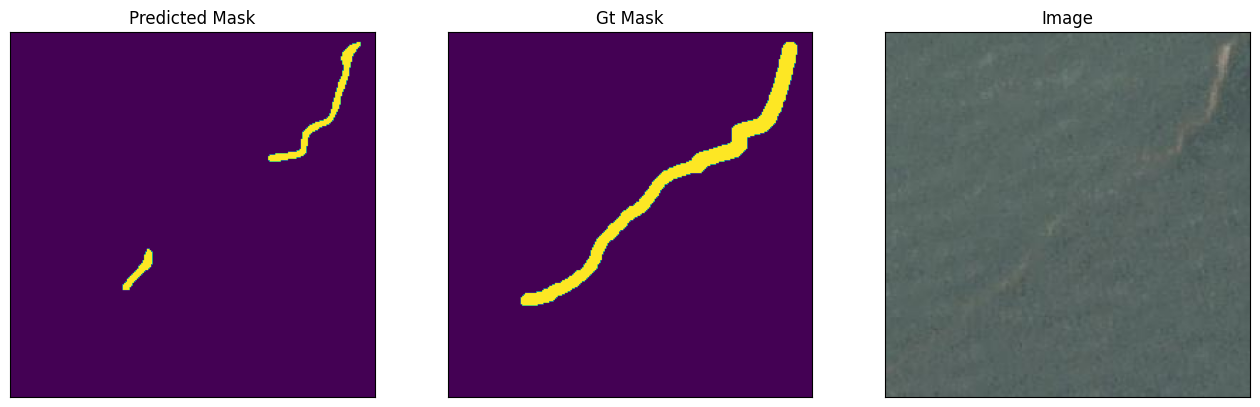

1/1 [==============================] - 0s 242ms/step


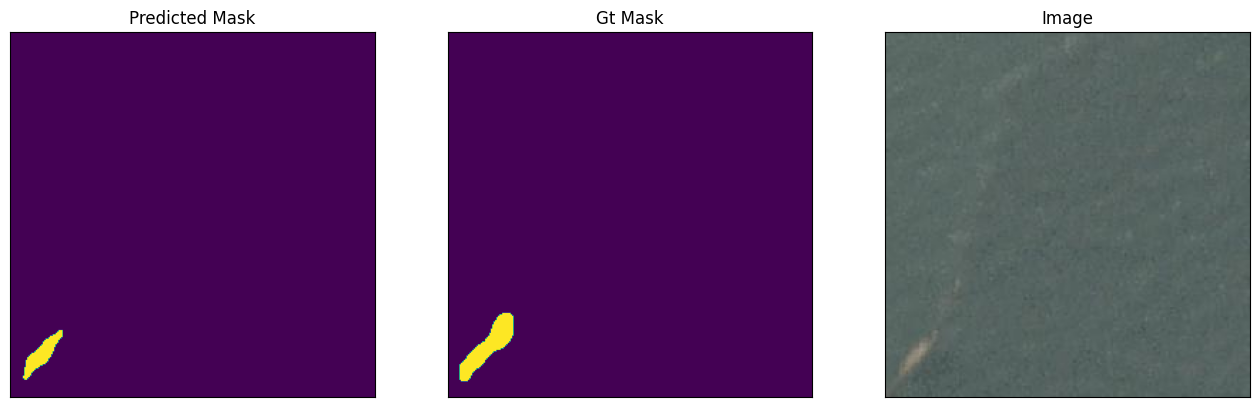

1/1 [==============================] - 0s 253ms/step


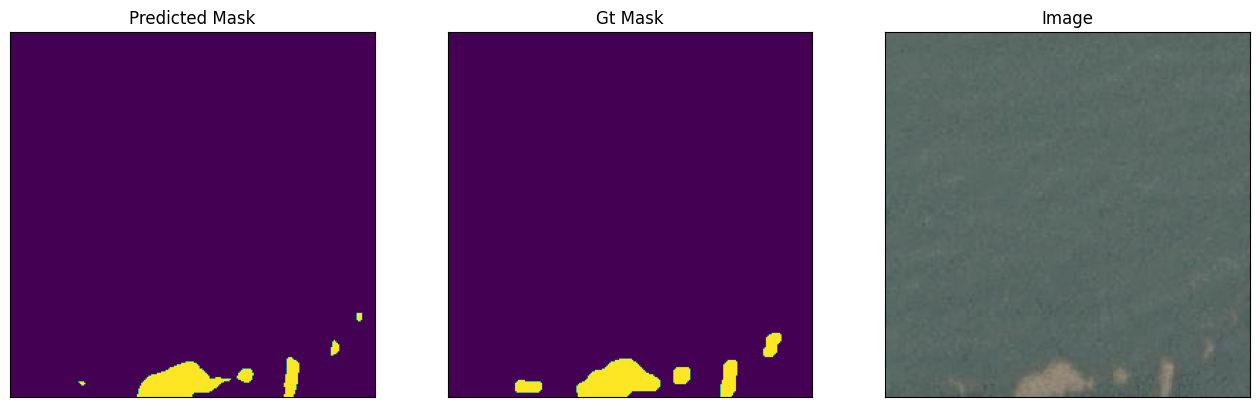

1/1 [==============================] - 0s 229ms/step


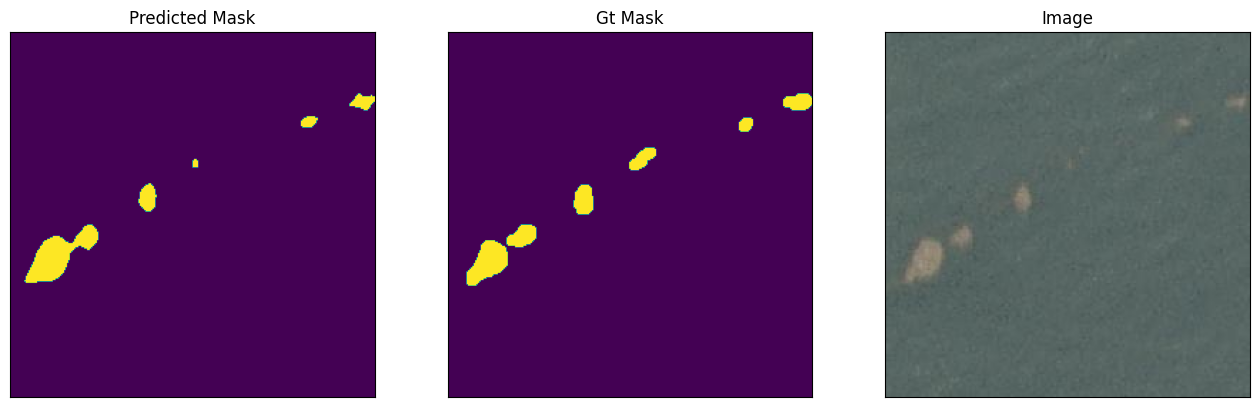

1/1 [==============================] - 0s 237ms/step


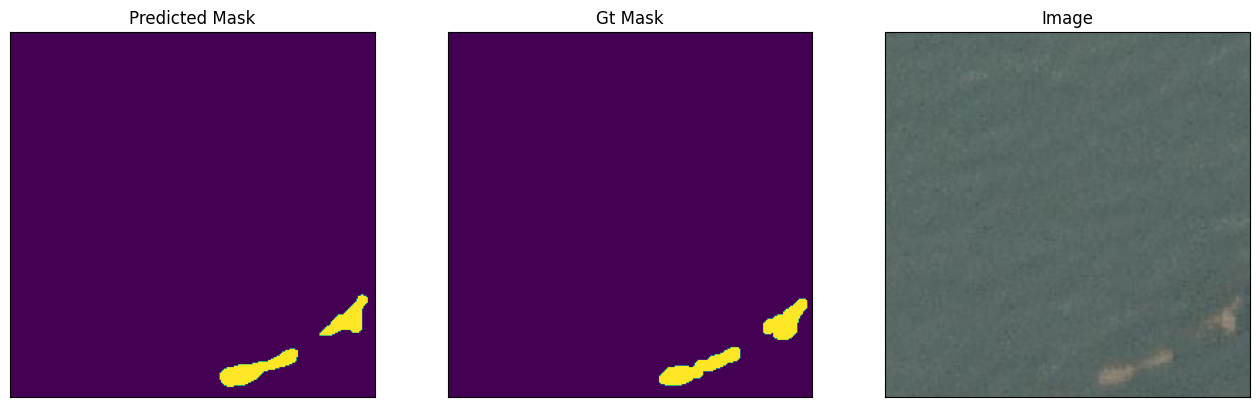

1/1 [==============================] - 0s 233ms/step


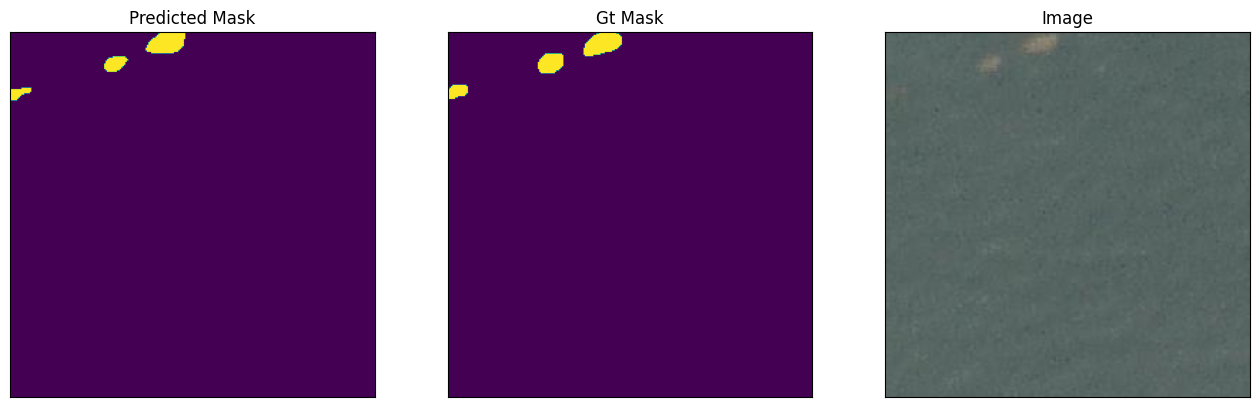

1/1 [==============================] - 0s 237ms/step


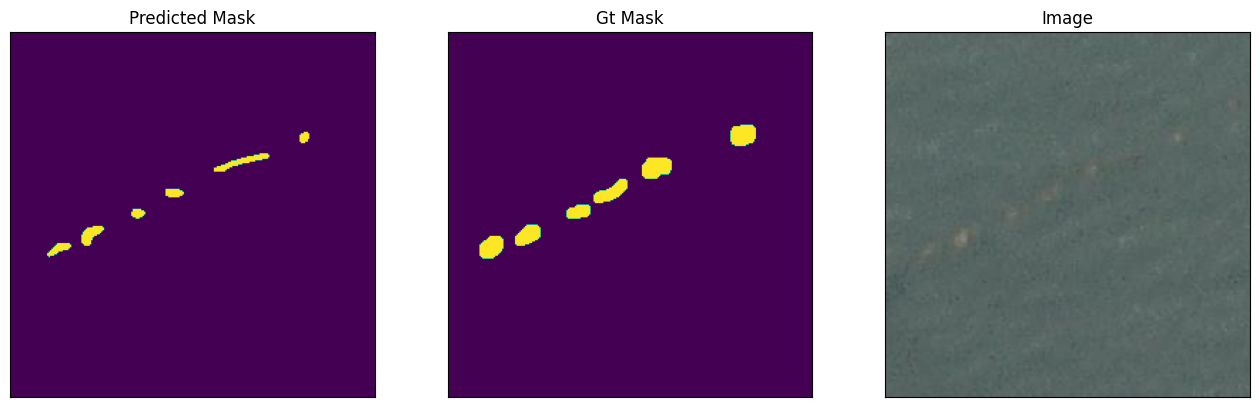

1/1 [==============================] - 0s 250ms/step


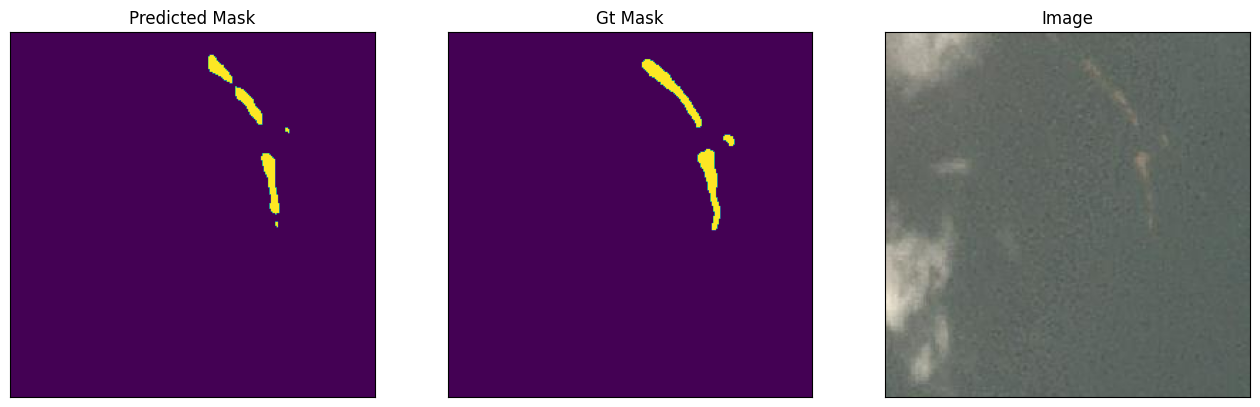

1/1 [==============================] - 0s 244ms/step


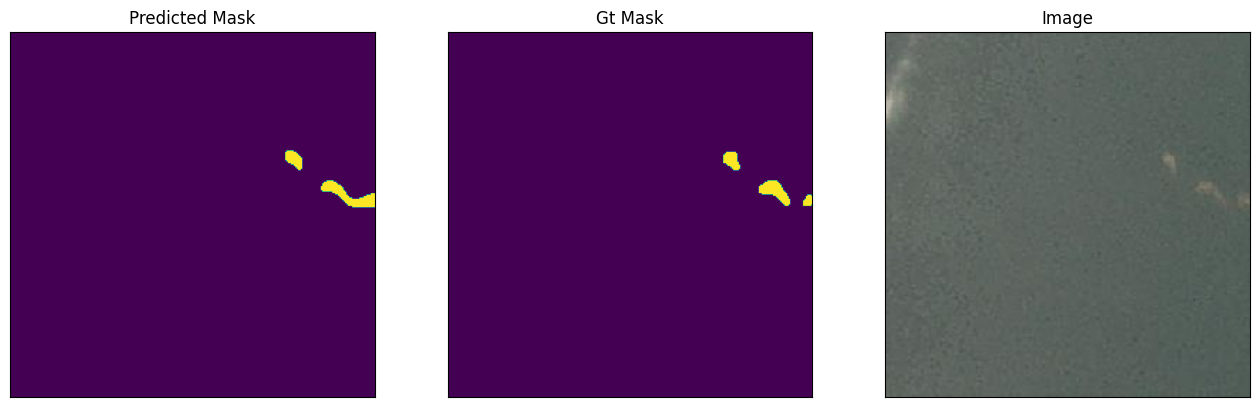

1/1 [==============================] - 0s 232ms/step


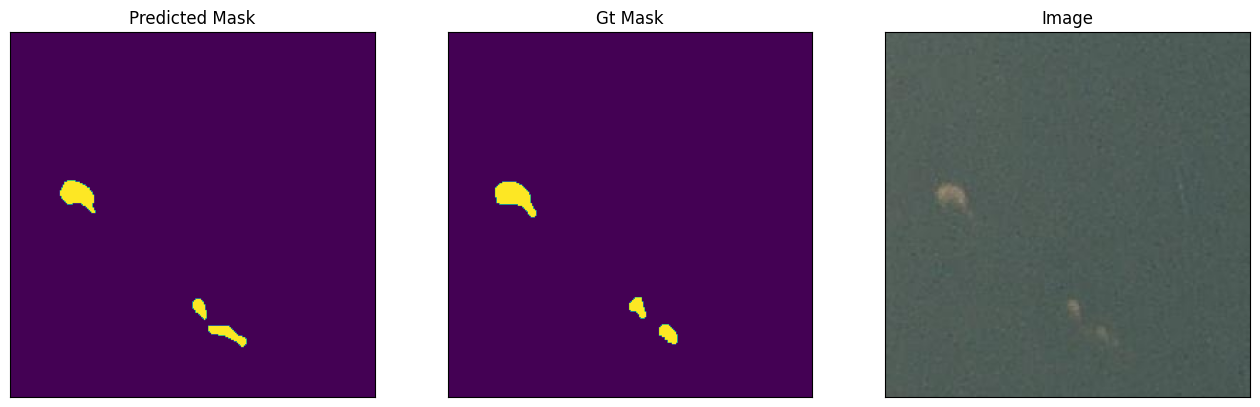

1/1 [==============================] - 0s 224ms/step


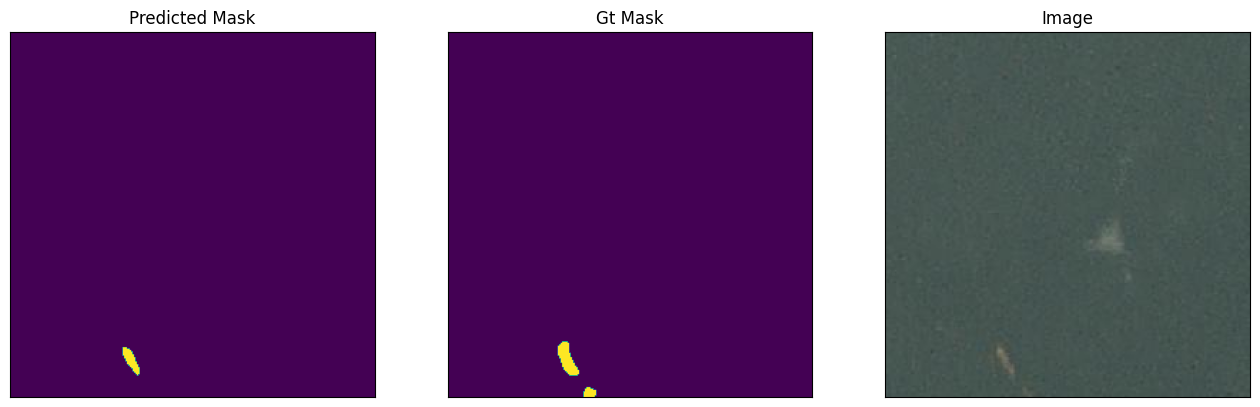

1/1 [==============================] - 0s 244ms/step


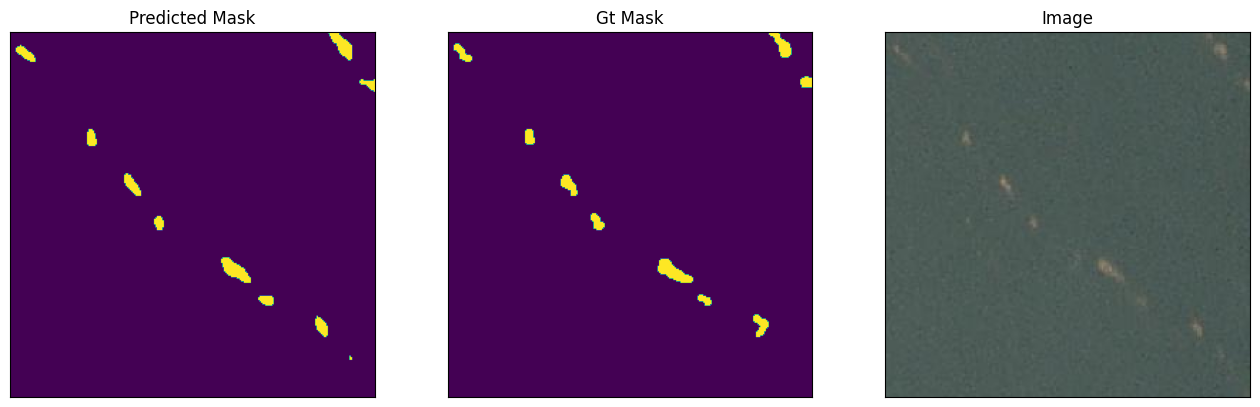

1/1 [==============================] - 0s 236ms/step


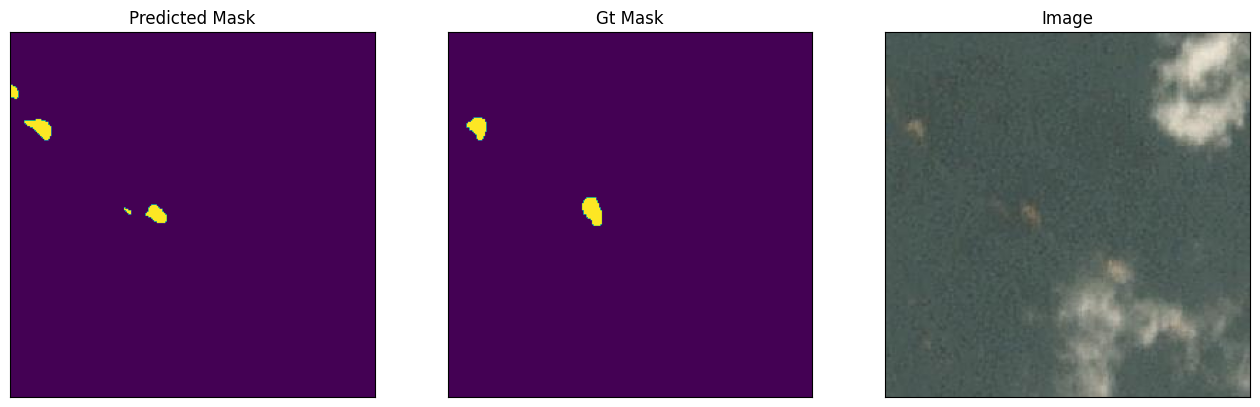

1/1 [==============================] - 0s 229ms/step


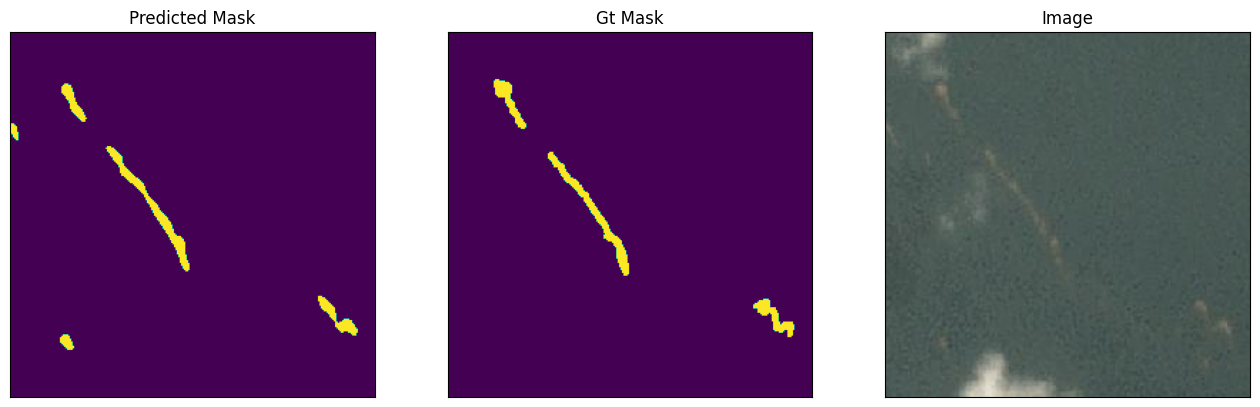

1/1 [==============================] - 0s 246ms/step


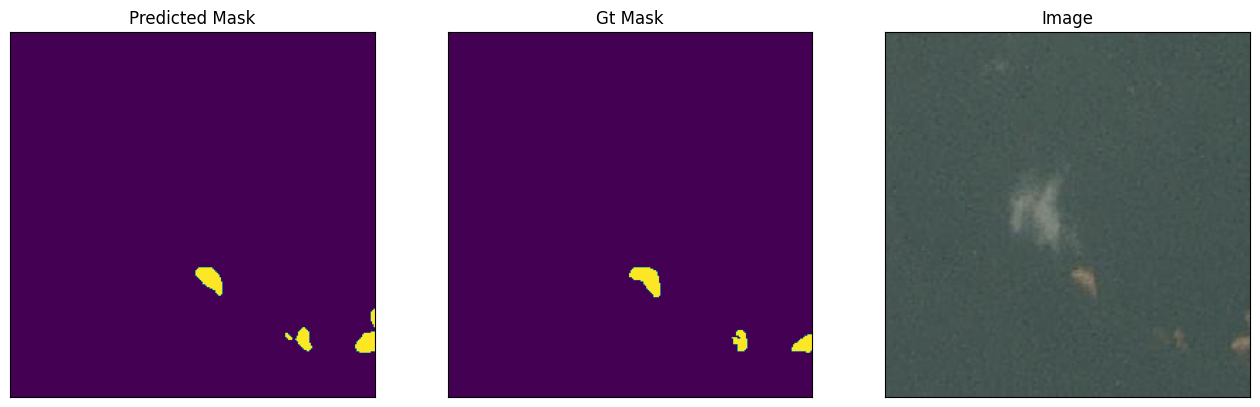

1/1 [==============================] - 0s 228ms/step


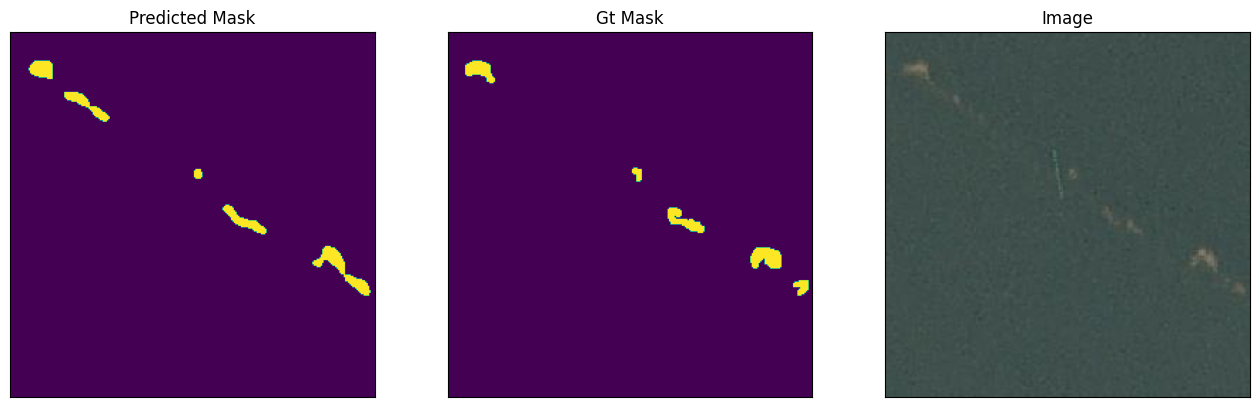

1/1 [==============================] - 0s 244ms/step


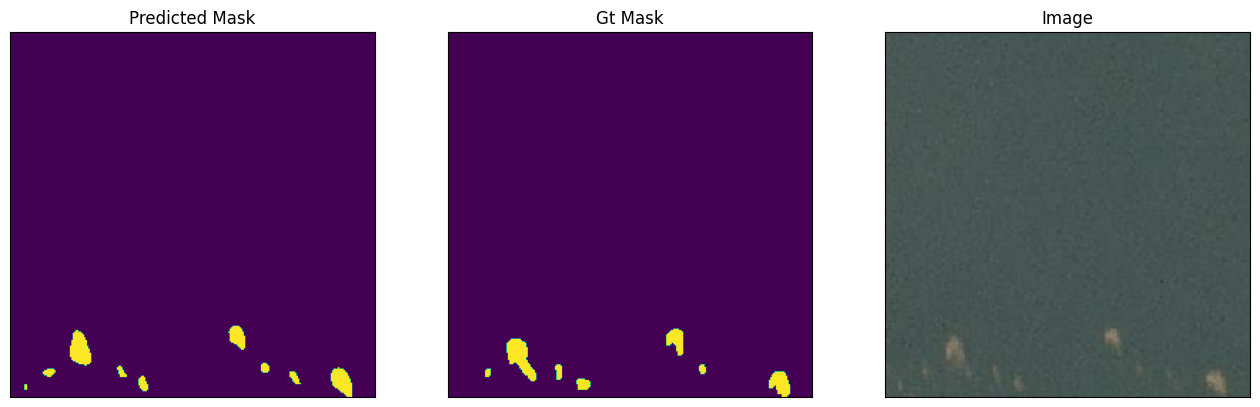

1/1 [==============================] - 0s 227ms/step


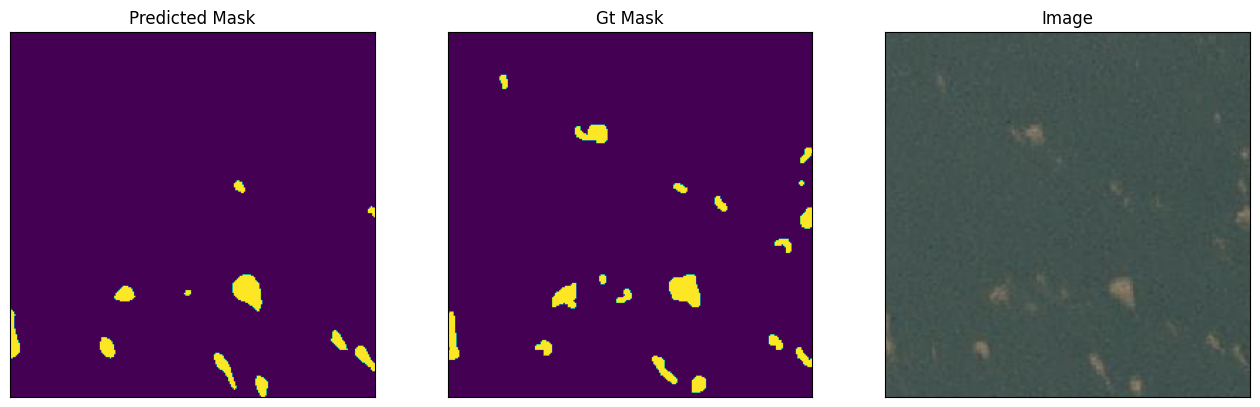

1/1 [==============================] - 0s 222ms/step


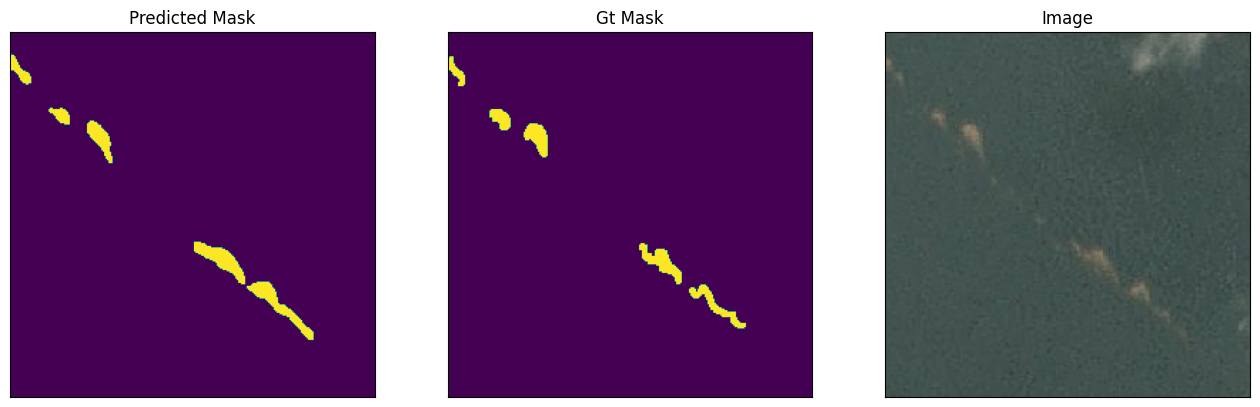

1/1 [==============================] - 0s 226ms/step


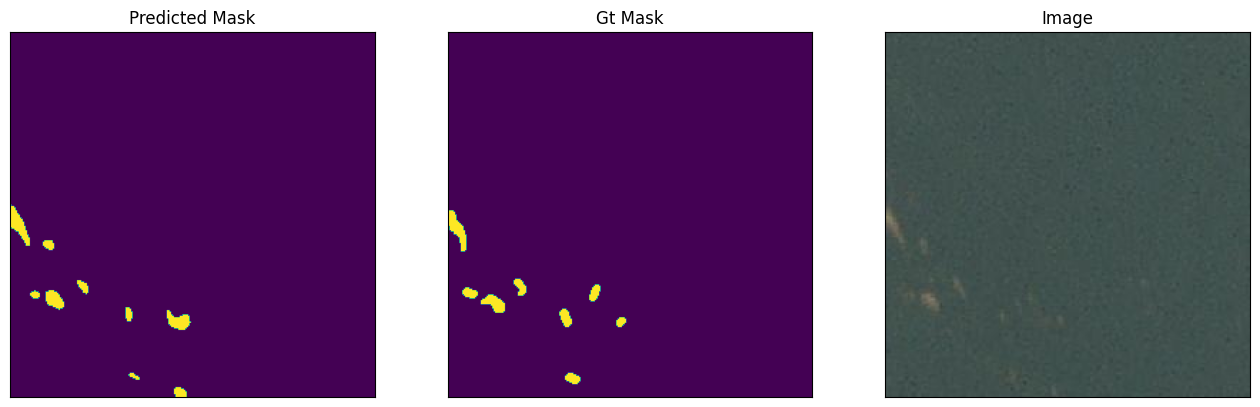

1/1 [==============================] - 0s 244ms/step


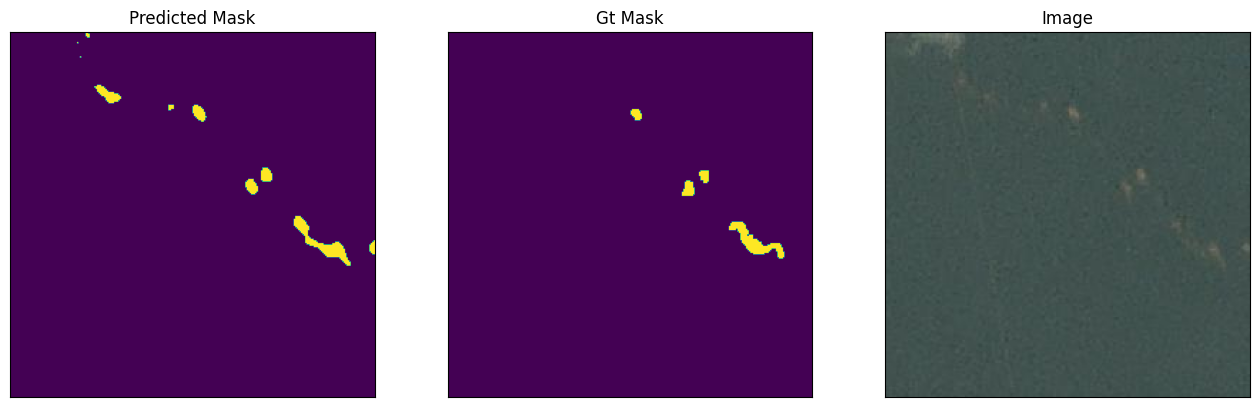

1/1 [==============================] - 0s 229ms/step


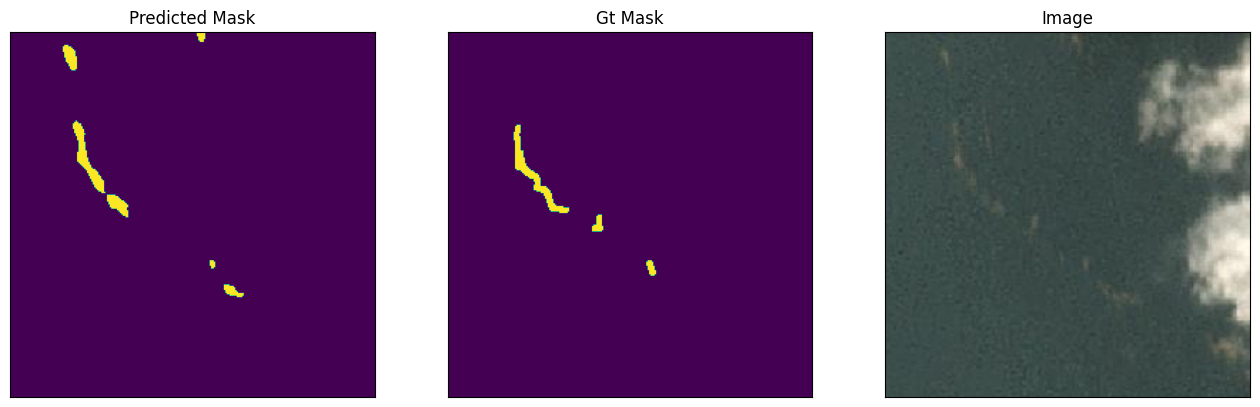

1/1 [==============================] - 0s 247ms/step


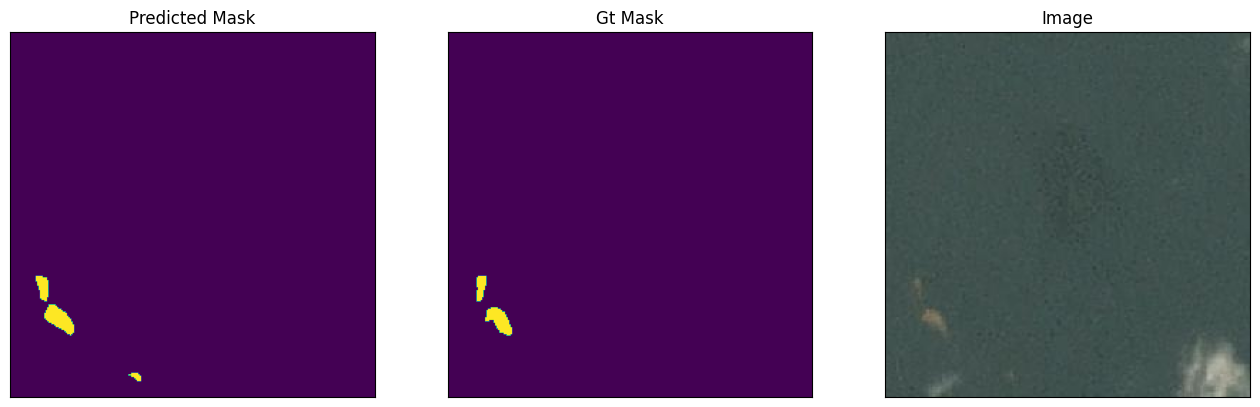

1/1 [==============================] - 0s 247ms/step


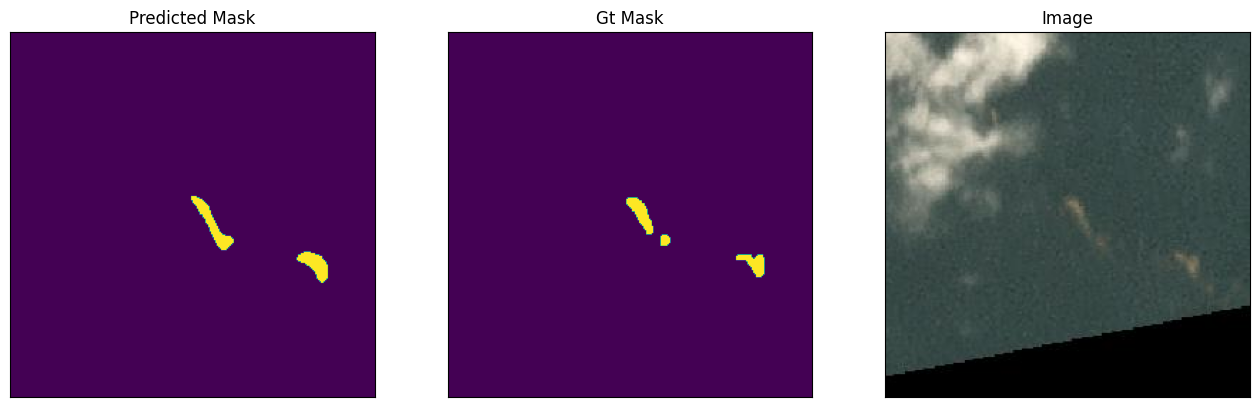

1/1 [==============================] - 0s 227ms/step


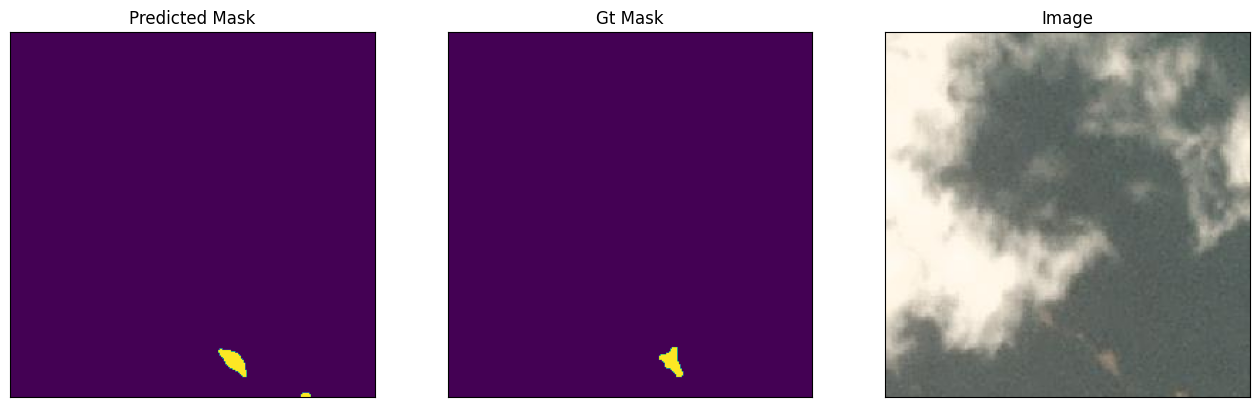

1/1 [==============================] - 0s 227ms/step


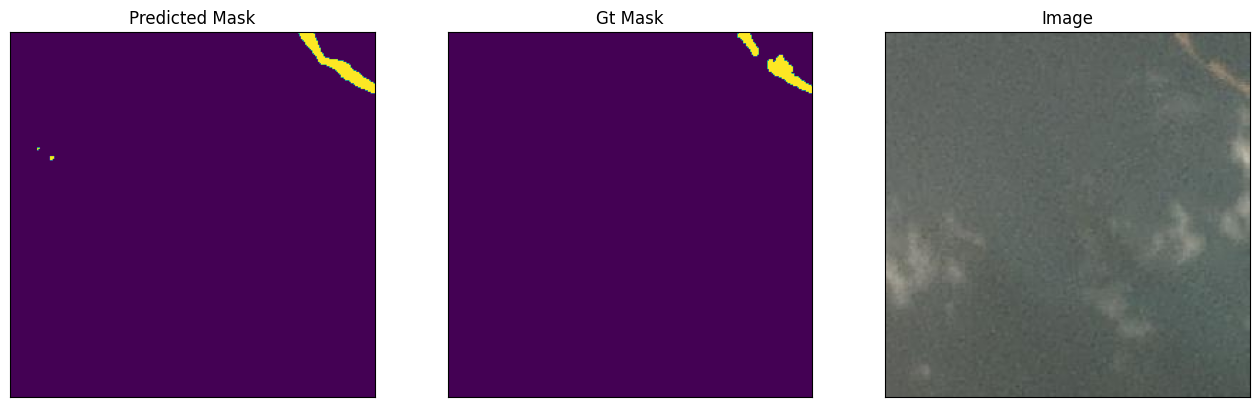

1/1 [==============================] - 0s 233ms/step


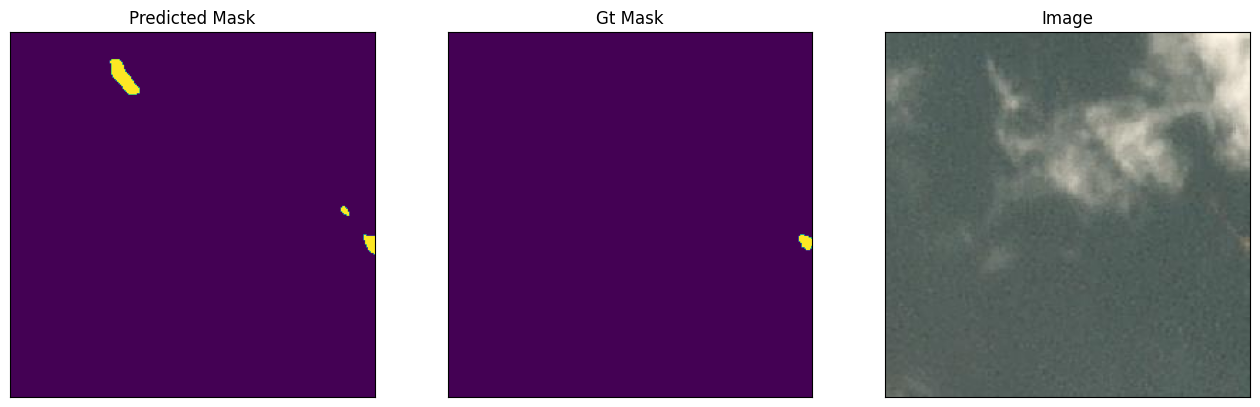

1/1 [==============================] - 0s 244ms/step


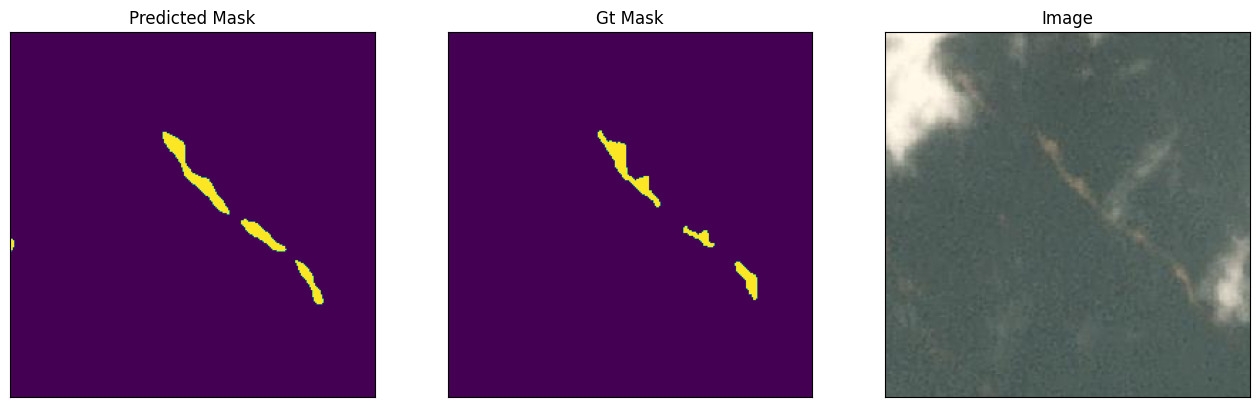

1/1 [==============================] - 0s 224ms/step


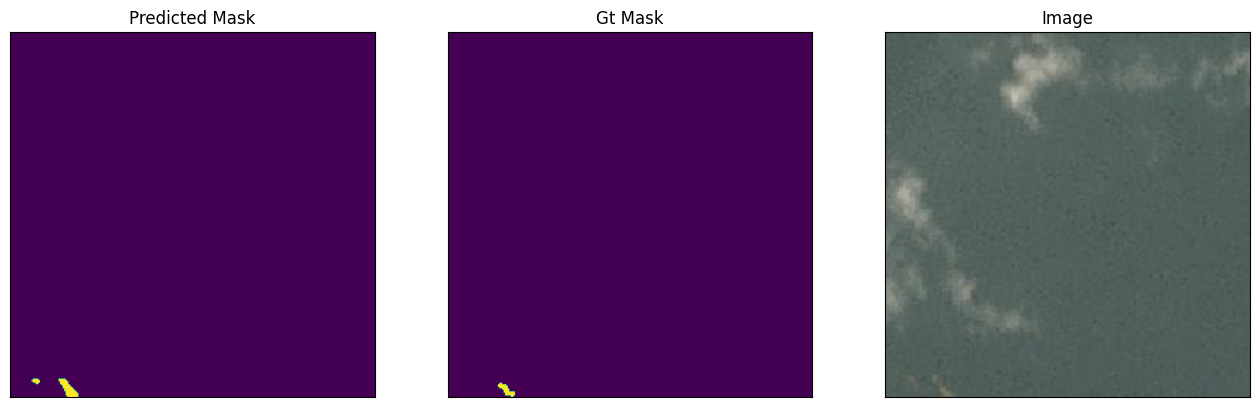

1/1 [==============================] - 0s 240ms/step


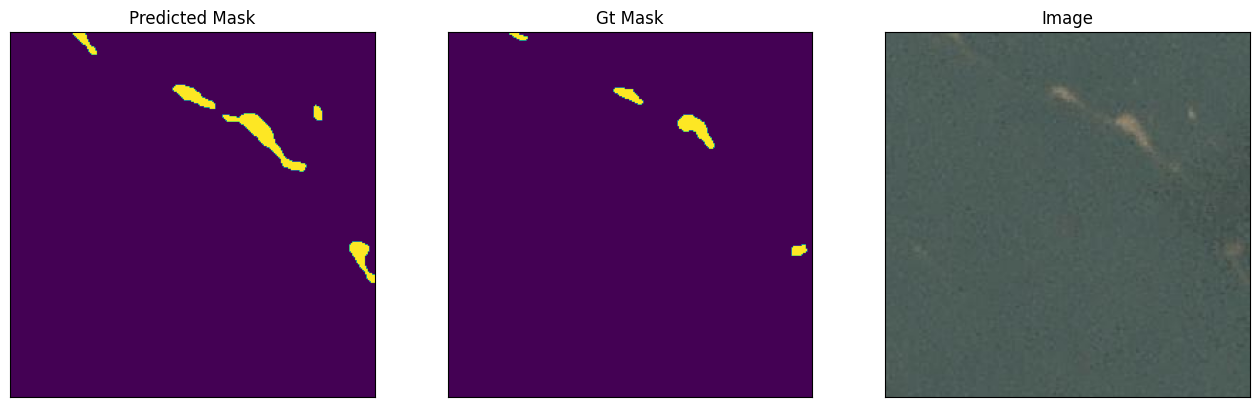

1/1 [==============================] - 0s 231ms/step


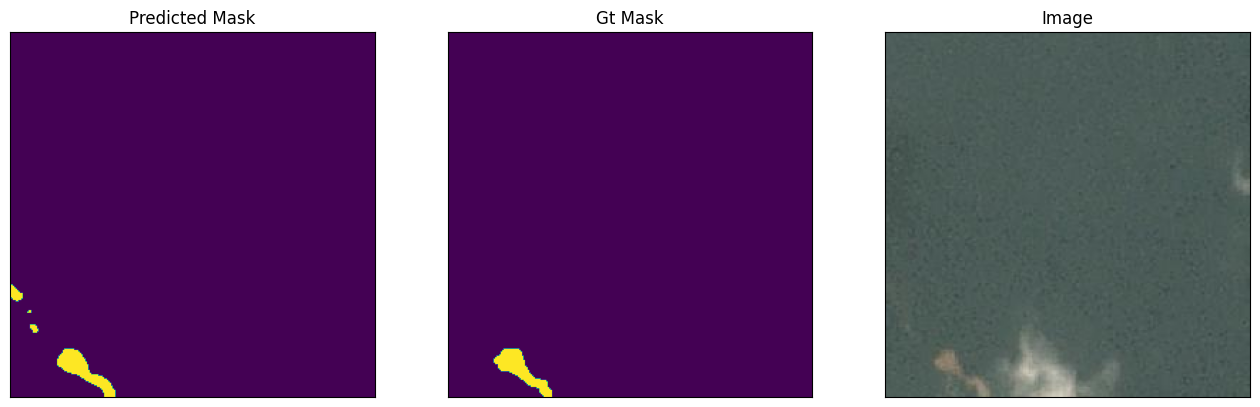

1/1 [==============================] - 0s 224ms/step


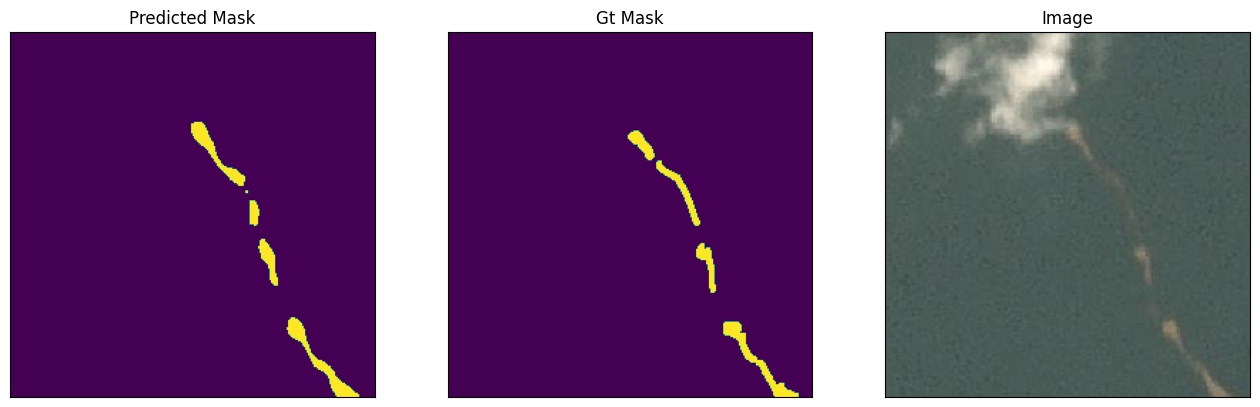

1/1 [==============================] - 0s 245ms/step


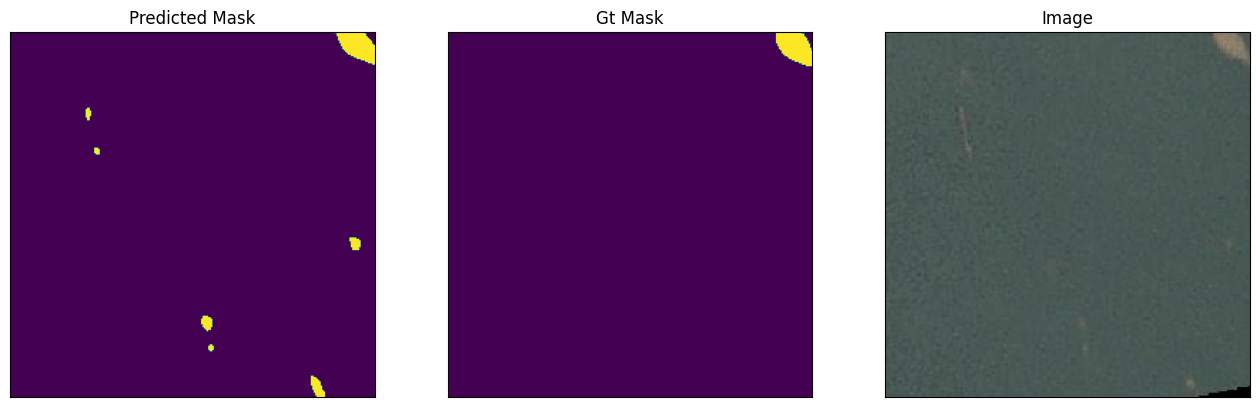

1/1 [==============================] - 0s 248ms/step


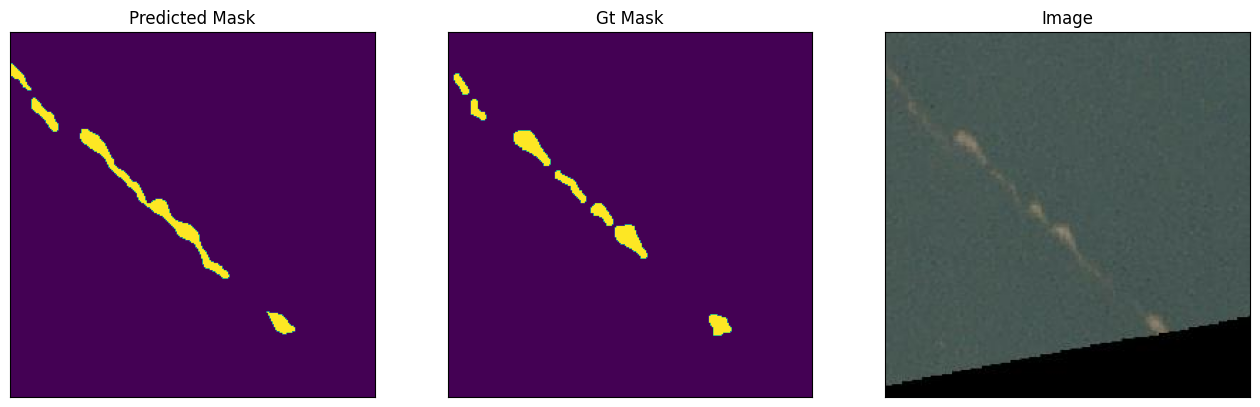

1/1 [==============================] - 0s 231ms/step


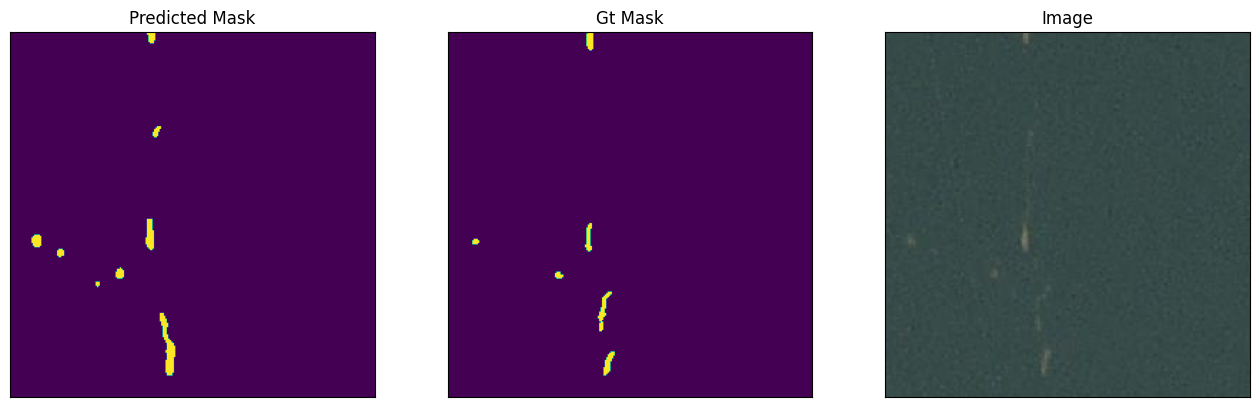

1/1 [==============================] - 0s 274ms/step


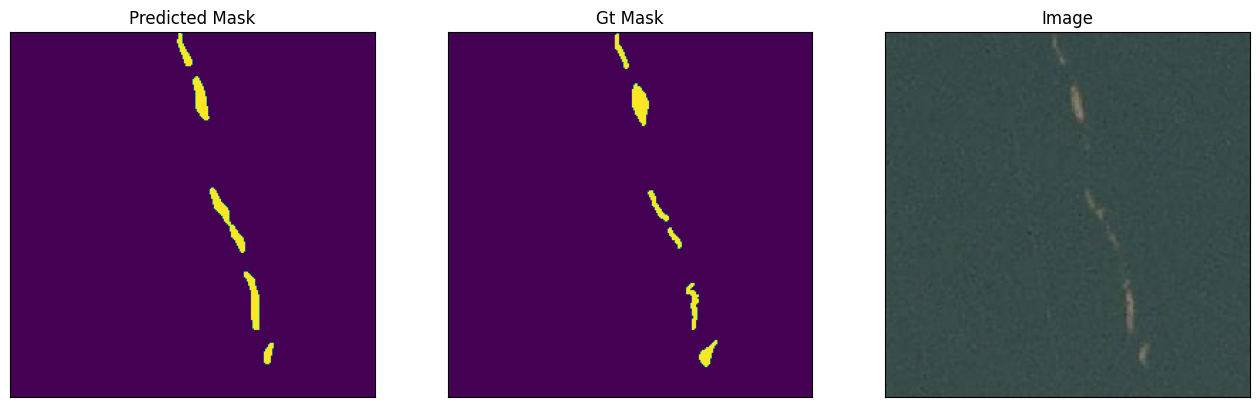

1/1 [==============================] - 0s 223ms/step


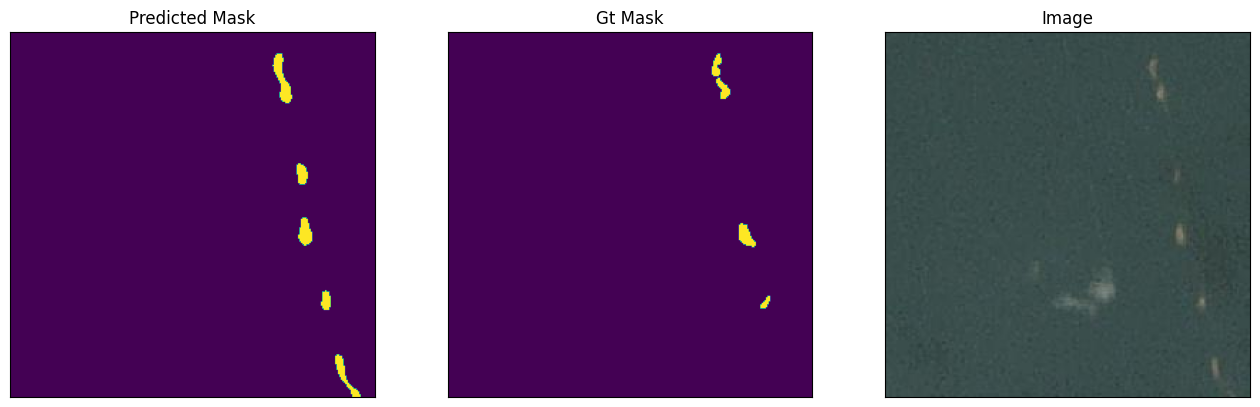

1/1 [==============================] - 0s 234ms/step


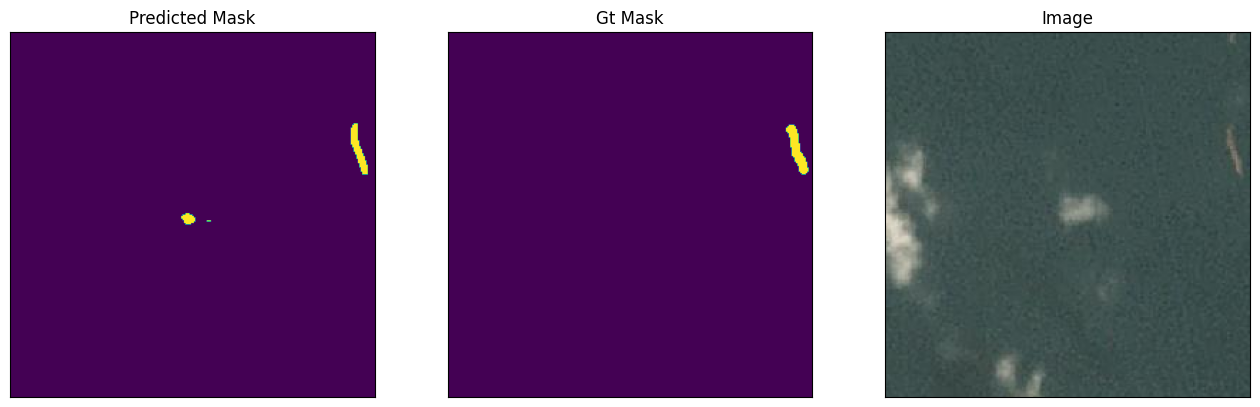

1/1 [==============================] - 0s 246ms/step


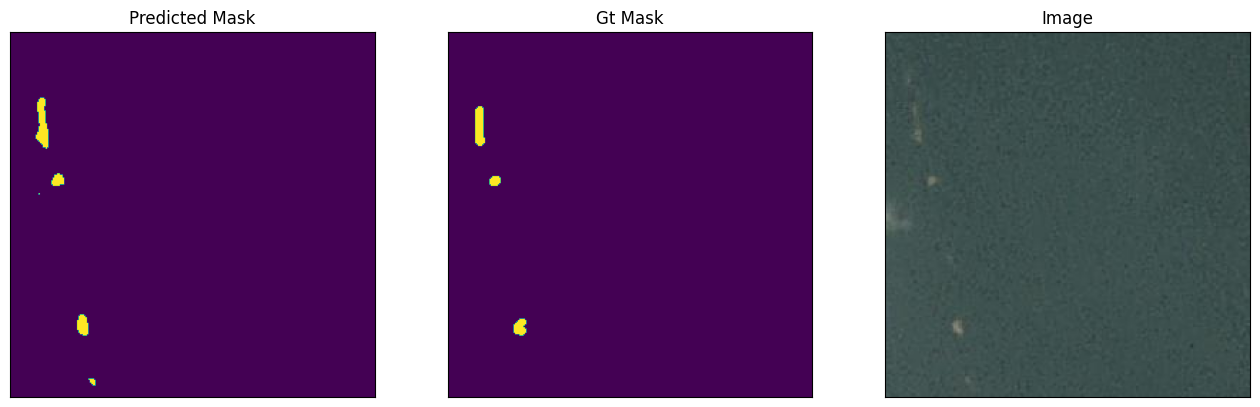

1/1 [==============================] - 0s 224ms/step


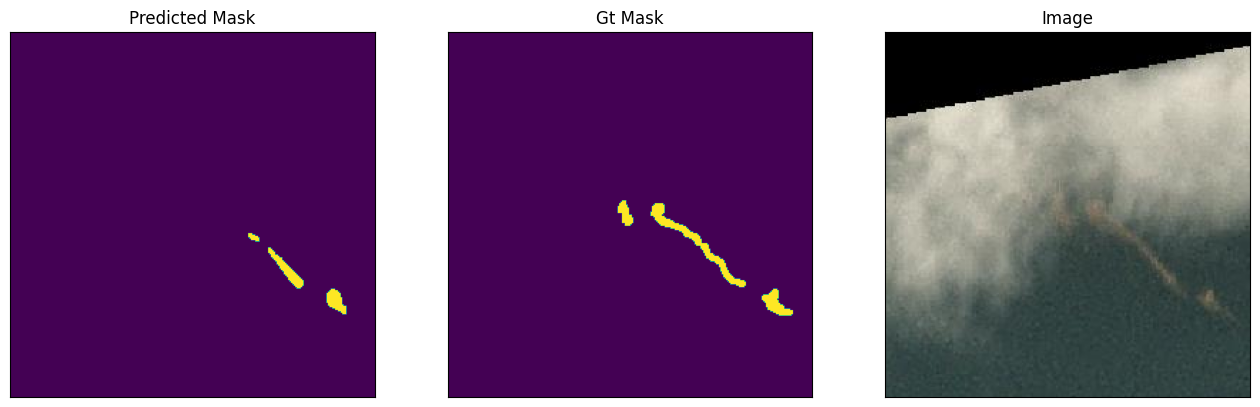

1/1 [==============================] - 0s 223ms/step


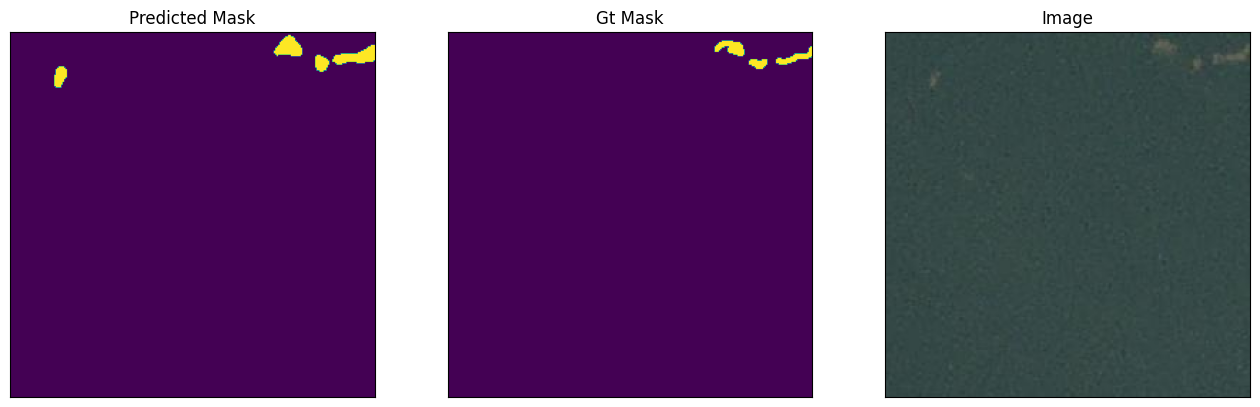

1/1 [==============================] - 0s 226ms/step


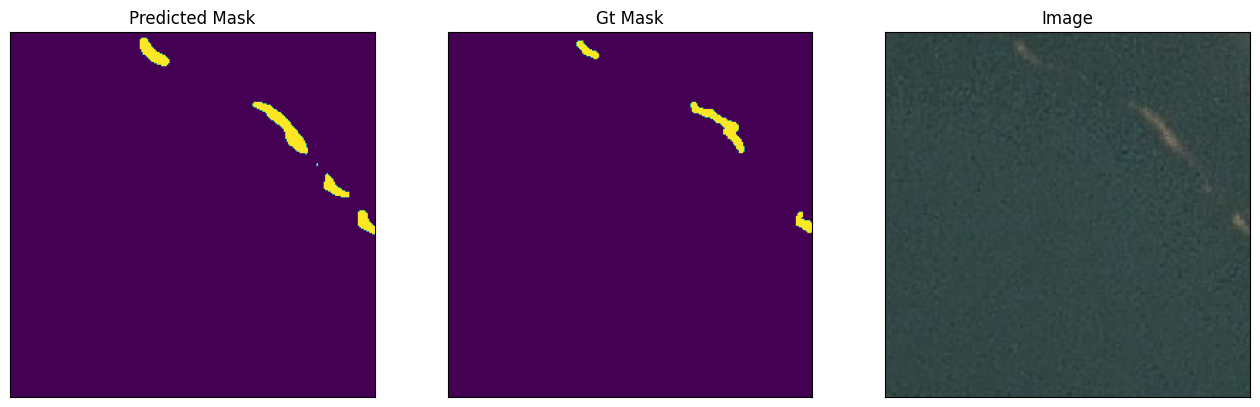

1/1 [==============================] - 0s 225ms/step


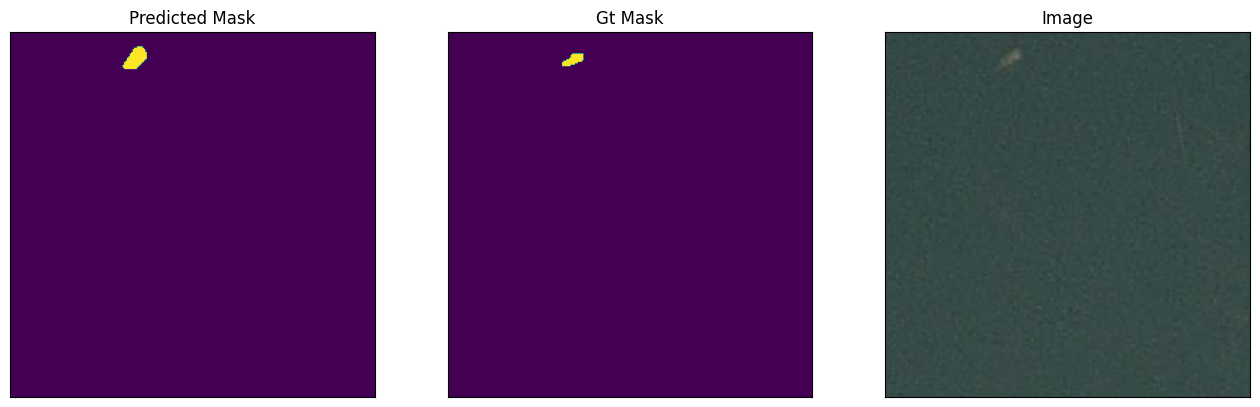

1/1 [==============================] - 0s 233ms/step


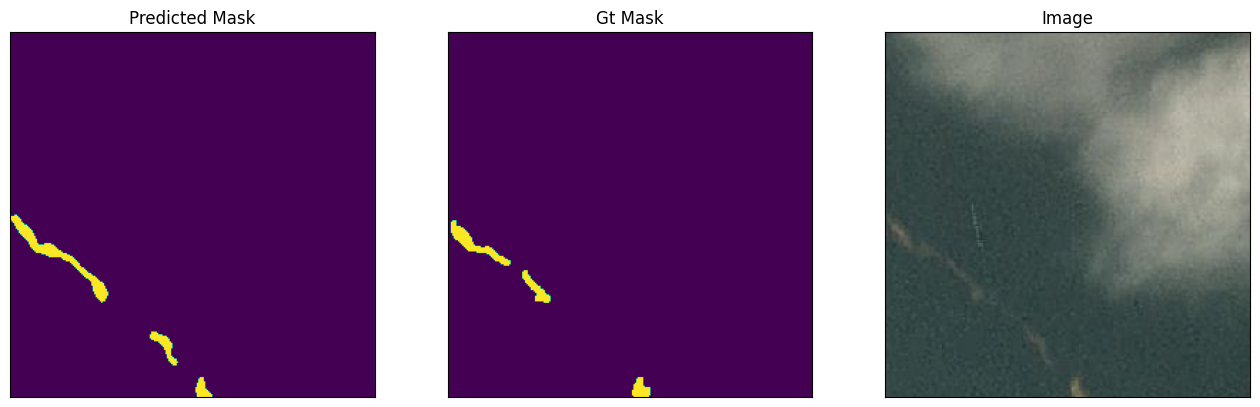

1/1 [==============================] - 0s 230ms/step


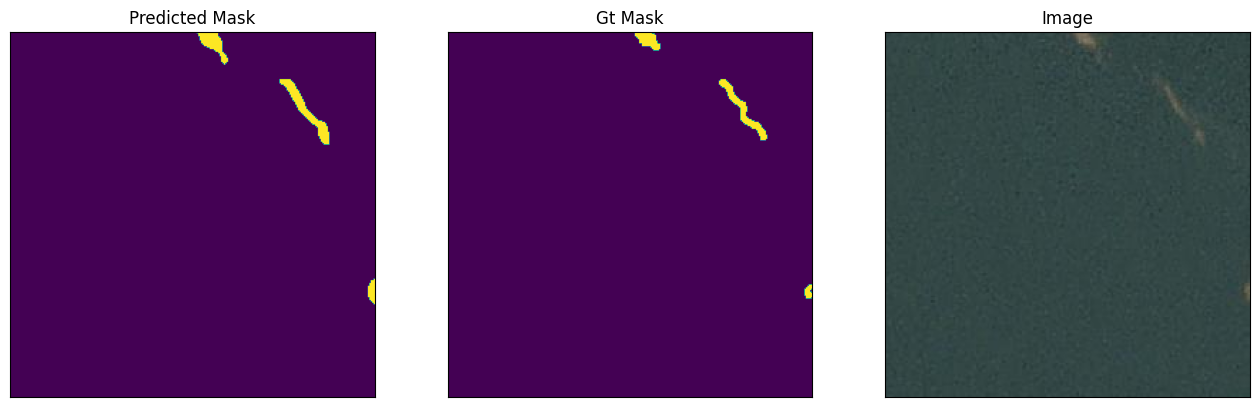

1/1 [==============================] - 0s 243ms/step


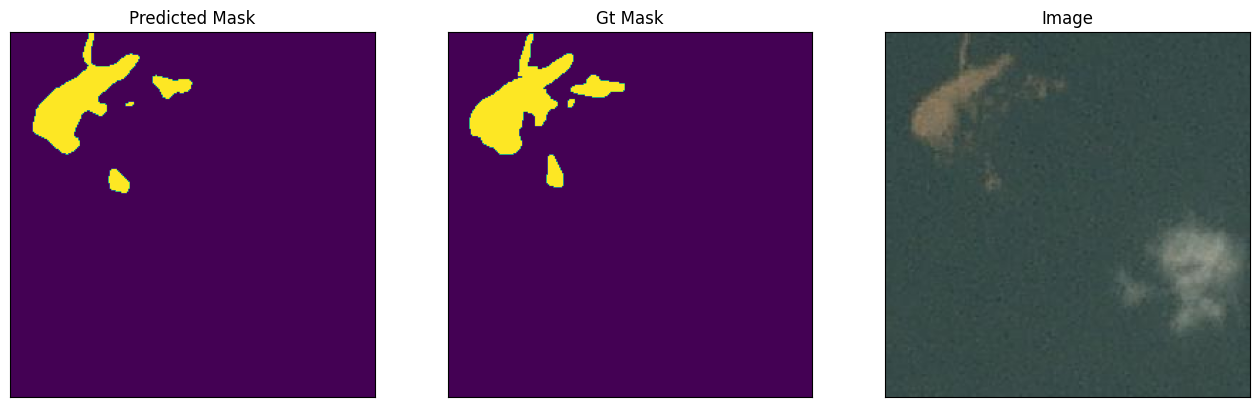

1/1 [==============================] - 0s 252ms/step


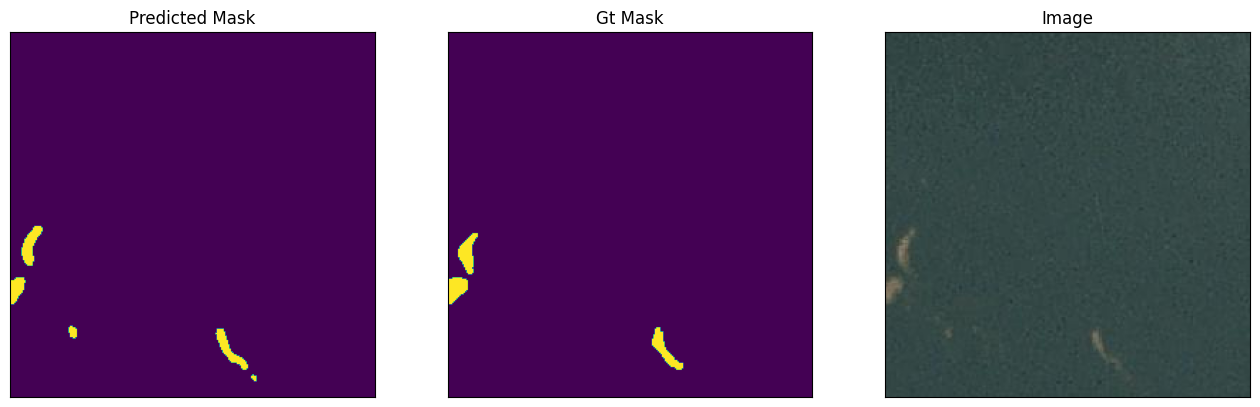

1/1 [==============================] - 0s 245ms/step


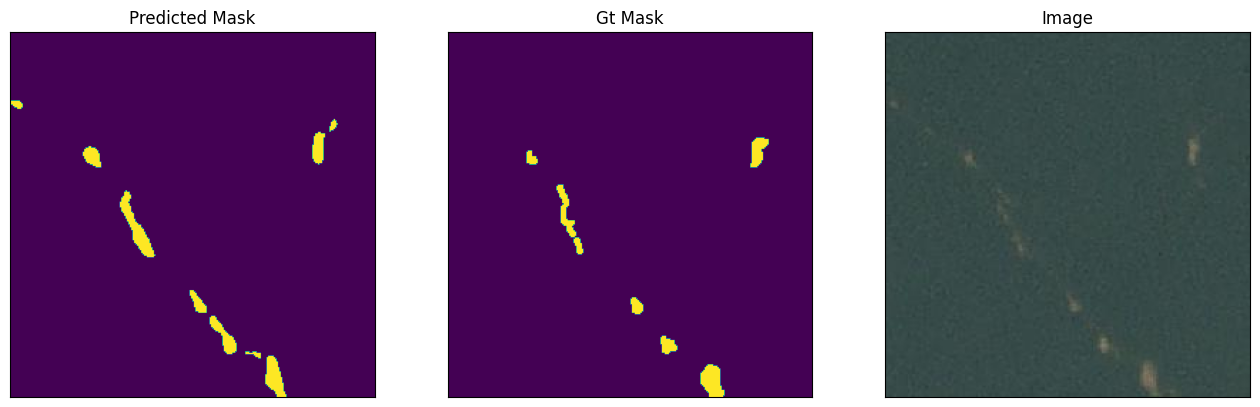

1/1 [==============================] - 0s 239ms/step


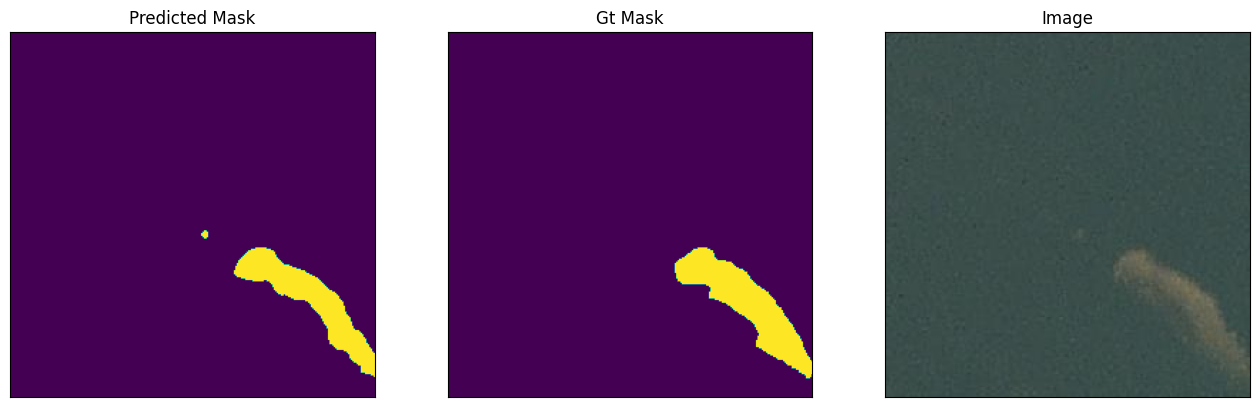

1/1 [==============================] - 0s 227ms/step


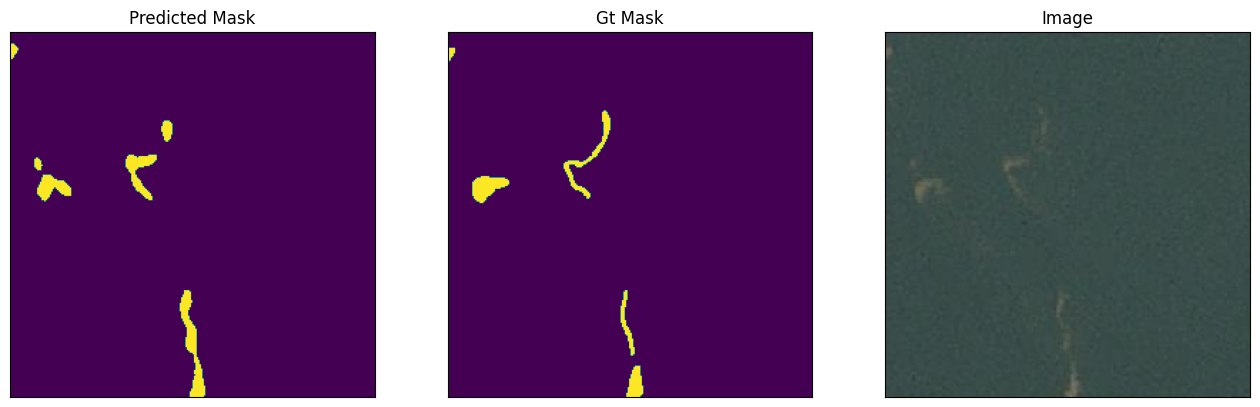

1/1 [==============================] - 0s 235ms/step


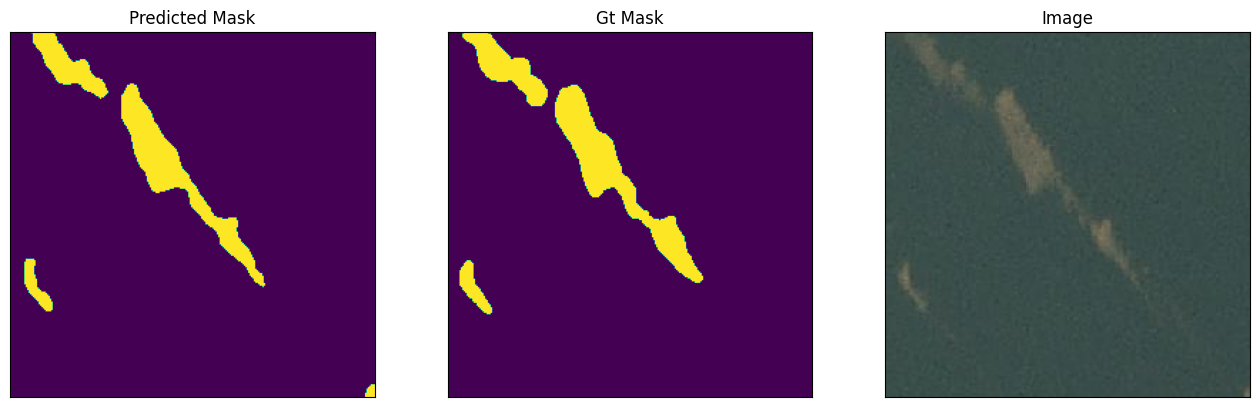

1/1 [==============================] - 0s 231ms/step


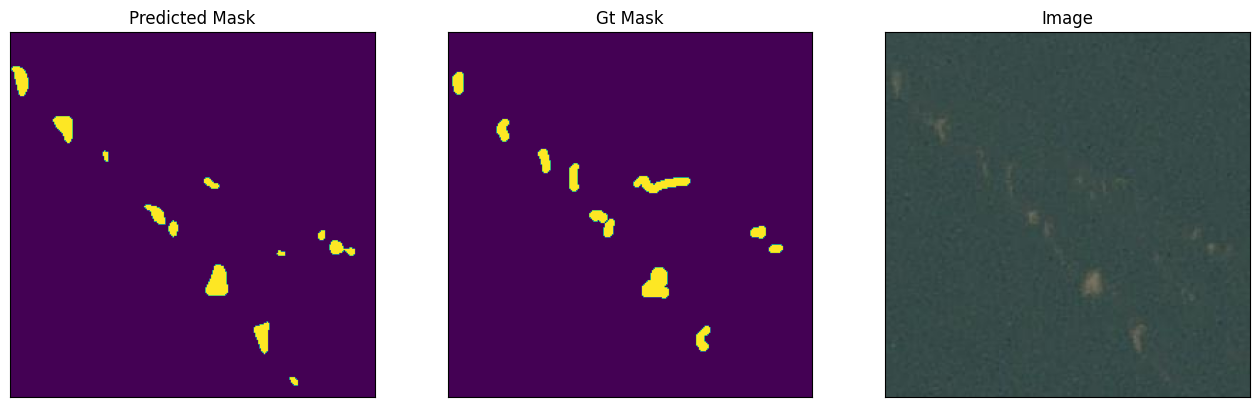

1/1 [==============================] - 0s 228ms/step


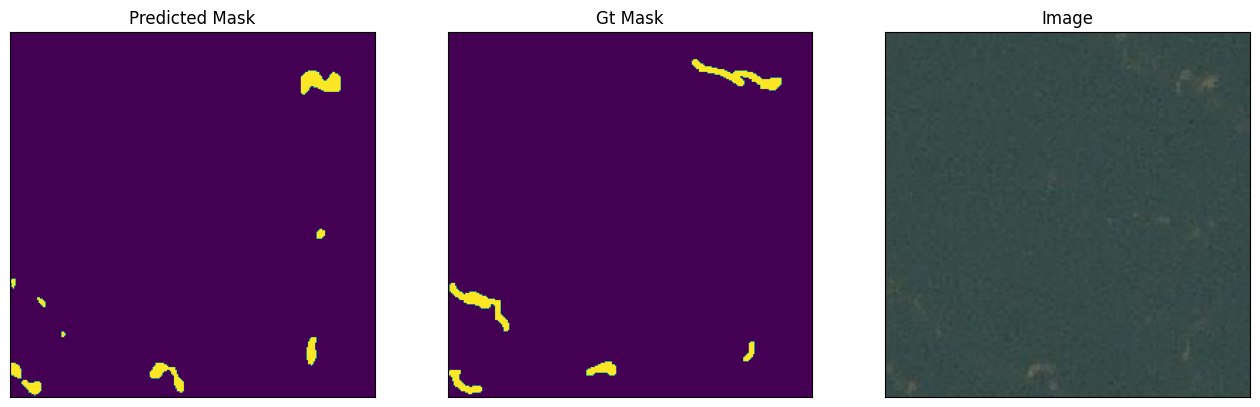

1/1 [==============================] - 0s 231ms/step


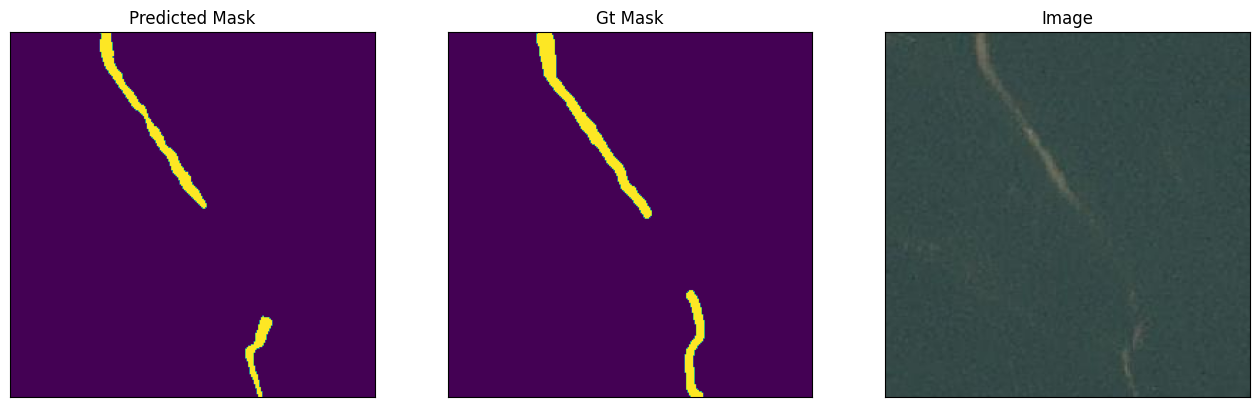

1/1 [==============================] - 0s 234ms/step


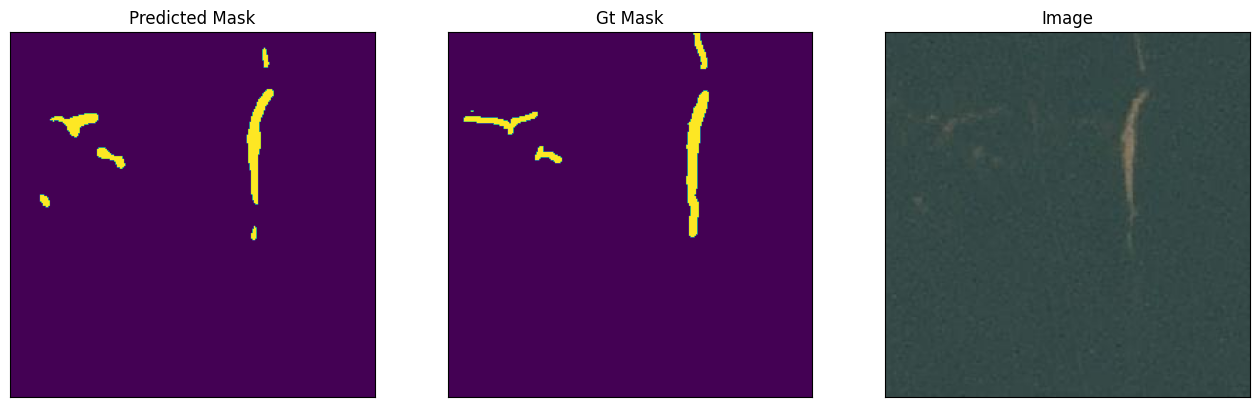

1/1 [==============================] - 0s 222ms/step


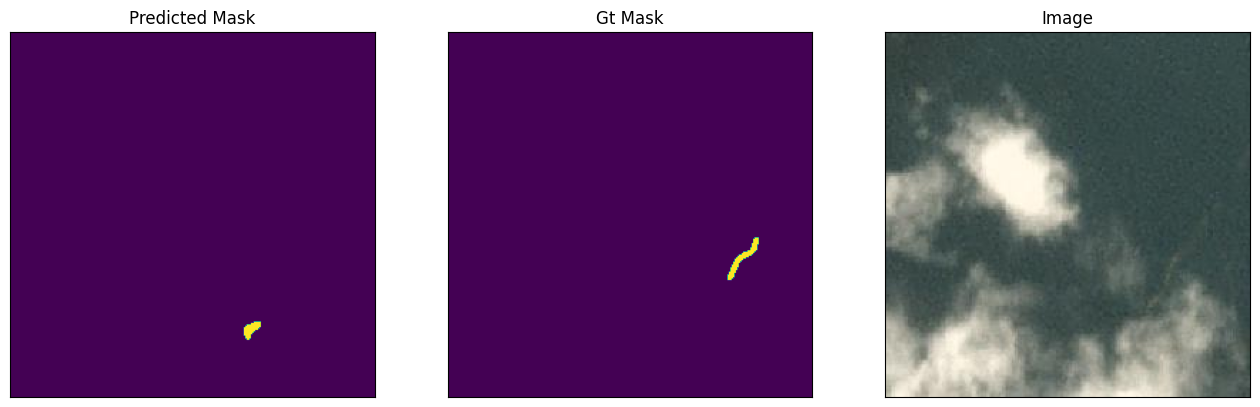

1/1 [==============================] - 0s 228ms/step


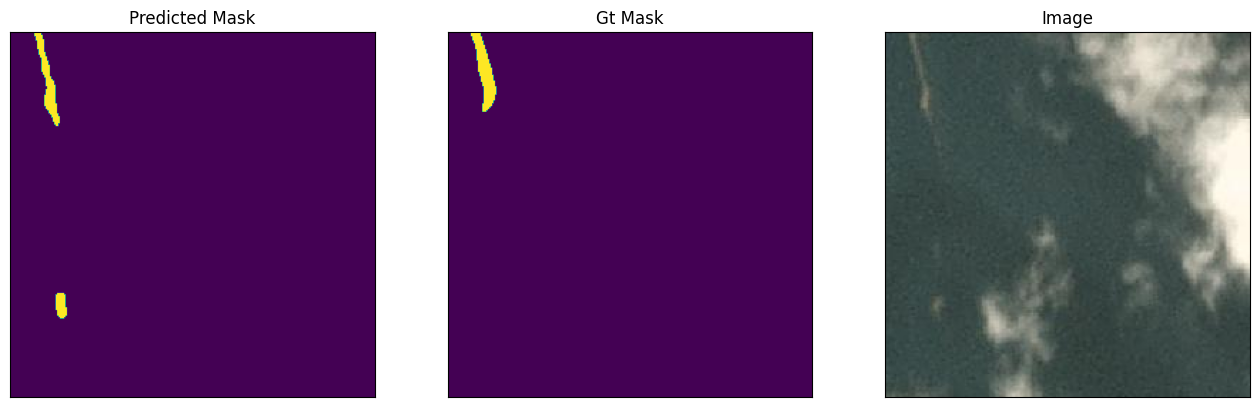

1/1 [==============================] - 0s 223ms/step


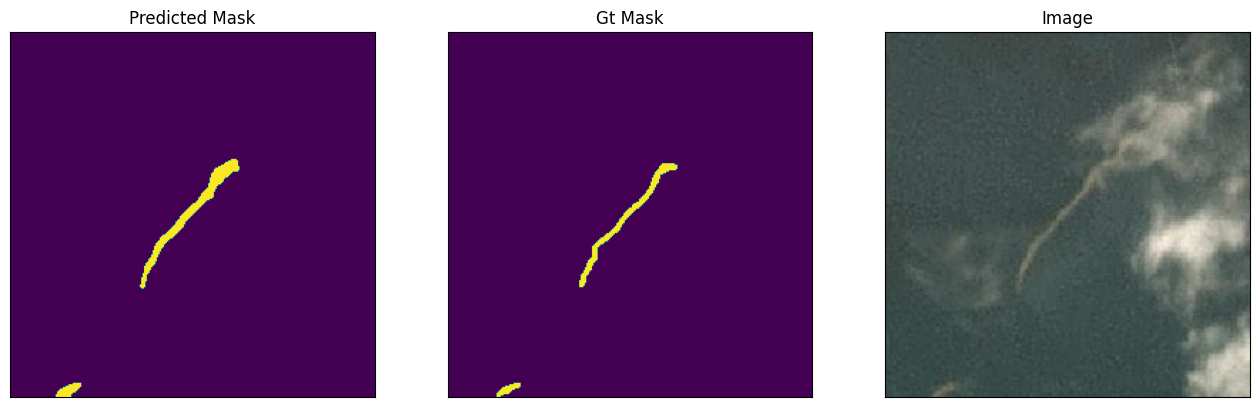

1/1 [==============================] - 0s 227ms/step


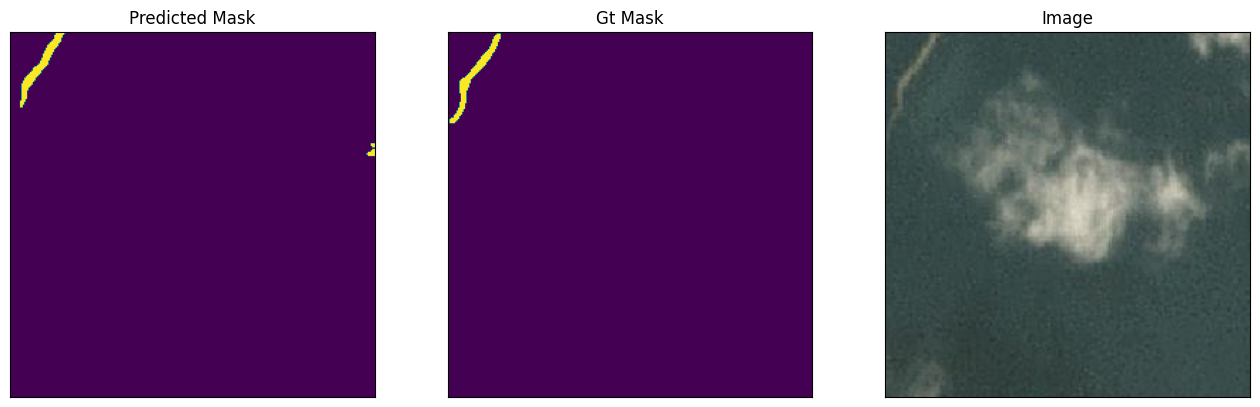

1/1 [==============================] - 0s 231ms/step


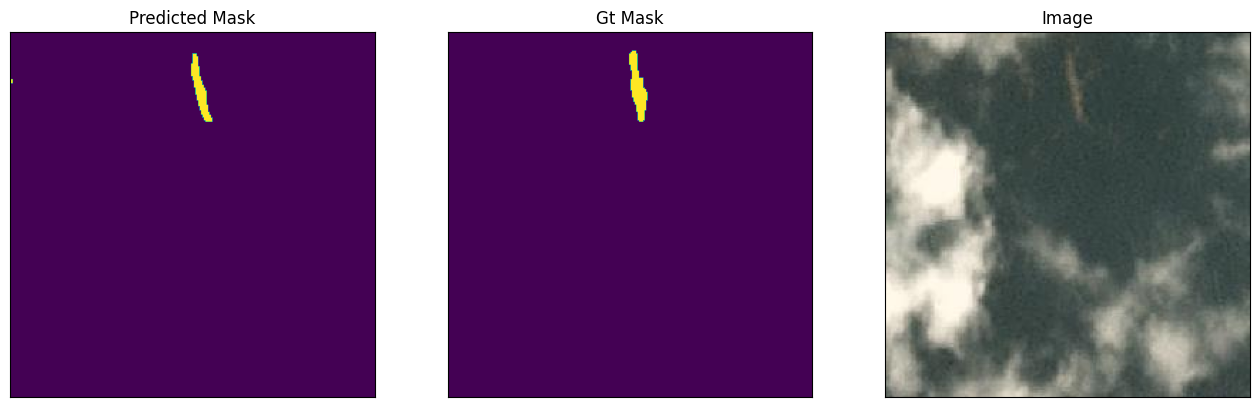

1/1 [==============================] - 0s 232ms/step


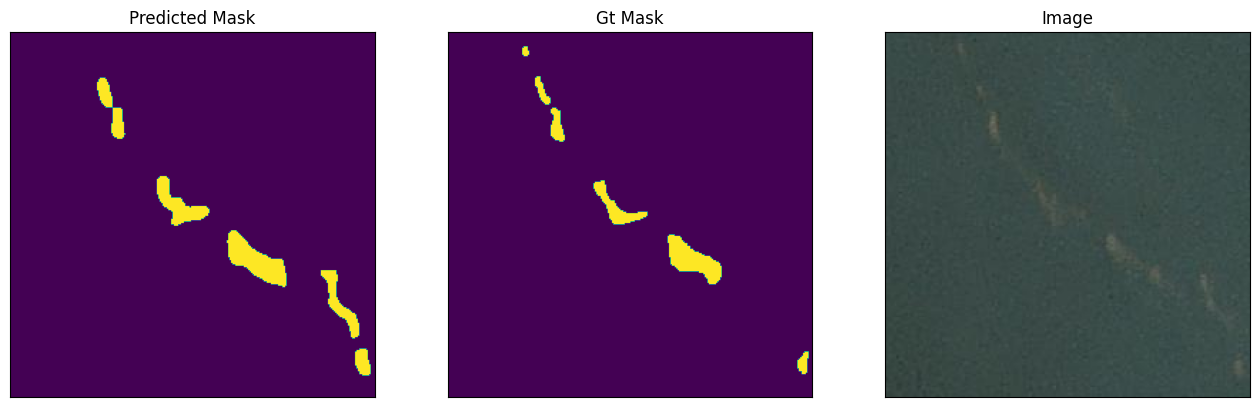

In [43]:
with tf.device('/GPU:0'):
    # checking predictions for best model
    for i in range(len(test_images)):
      prediction = predict(model_efficientnetb4, test_images[i])
      visualize(
          predicted_mask=prediction,
          gt_mask=test_masks[i],
          image=test_images[i]
      )